In [1]:
using Plots
using ForwardDiff
using ProgressMeter

In [293]:
function sample!(x,θ)
    T = size(θ,2)
    for t = 1:T-1
        x[t+1] = x[t] + ( rand() < θ[x[t] + T, t] ? 1 : -1 )
    end
end

sample! (generic function with 1 method)

In [294]:
function logqt(x,θt,t)
    return log((x[t+1] - x[t]) == 1 ? θt[x[t] + T] : 1 - θt[x[t] + T])
end

function logQ(x,θ)
    T = size(θ,2)
    s = 0
    for t = 1:T-1
        s += logqt(x,θ[:,t],t) 
    end
    return s
end

function isok(x)
    return   9 <= abs(x[end]) <= 10
end

function logO(x)
    if isok(x)
        return 0
    else
        return -100
    end
end

logO (generic function with 1 method)

In [295]:
function gradient!(dθ, x, θ)
    T = size(θ,2)
    for t = 1:T-1
        ForwardDiff.gradient!((@view dθ[:,t]), θt -> logqt(x,θt,t), θ[:,t])
    end
end

gradient! (generic function with 1 method)

In [296]:
function descend!(θ, θp, θmin, θmax; numsamples=10^4, numiters=100, η=0.1)
    N, T = size(θ)
    dθ = zero(θ)
    x = zeros(Int, T)
    pr = Progress(numiters) 
    avF = 0
    for it = 1:numiters
        avF = 0
        Dθ = zero(θ)
        for s = 1:numsamples
            sample!(x, θ)
            F = logQ(x,θ) - logQ(x,θp) - logO(x)
            avF += F / numsamples
            gradient!(dθ, x, θ)
            Dθ .+= F .* dθ ./ numsamples
        end
        θ .-= sign.(Dθ) .* abs.(θ) .* η
        θ .= clamp.(θ, θmin, θmax)
        ProgressMeter.next!(pr, showvalues=[(:F,sum(avF))])
    end
    return avF
end

descend! (generic function with 1 method)

In [313]:
T = 100 #total time of movement
N = 2T - 1

θ = fill(1/2,N,T); 
#This is an N x T matrix where θ[i,t] represents 
#the probability of jumping to right at time t for particle i
#The prob of jumping to left is 1-θ[i,t]
dθ = fill(1/2,N,T); 

θp = fill(1/2,N,T); 

x = zeros(Int,T);

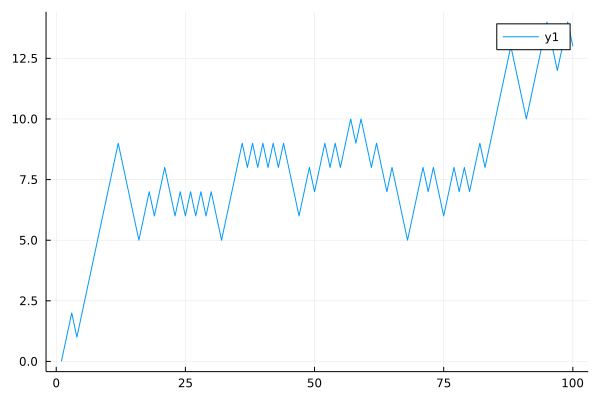

In [314]:
sample!(x,θp)
plot(x)

In [ ]:
avF = descend!(θ, θp, 1e-4, 1-1e-4; numsamples=500, numiters=300, η=0.01)

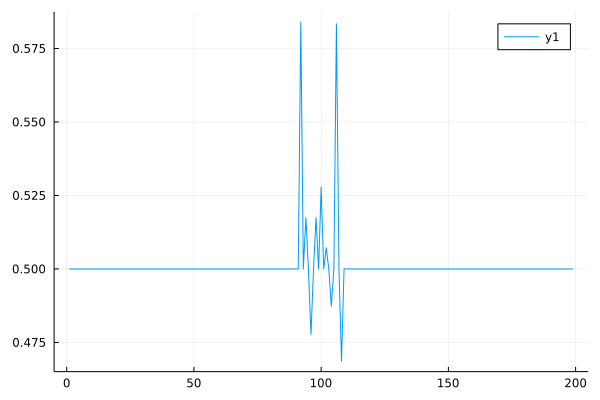

In [316]:
plot(θ[:,9])

In [317]:
logQ(x,θ)

-71.71602941449228

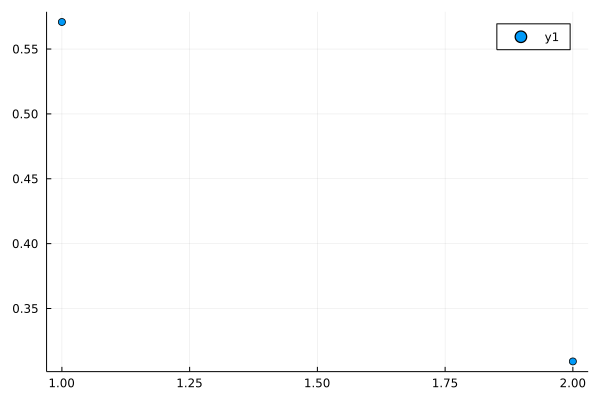

In [318]:
isto = zeros(2)
total = 15000
for st = 1:total
    sample!(x,θ)
    if x[end] == 9
        isto[1] += 1
    elseif x[end] == -9
        isto[2] += 1
    end
end
scatter(isto ./ total)

In [319]:
isto ./ total


2-element Vector{Float64}:
 0.5708666666666666
 0.3092

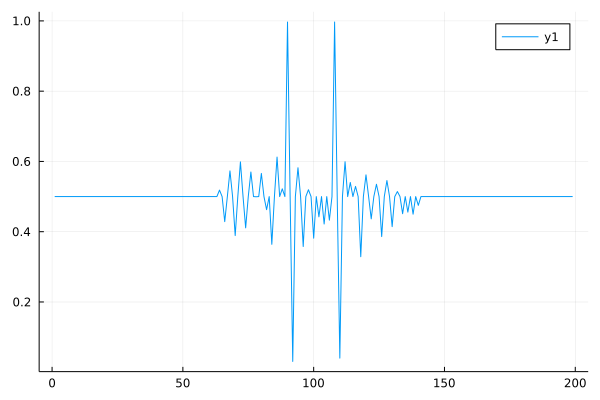

In [292]:
plot(θ[:,end-1])